In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML, Math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

## Bode diagram ábrázolása

A példa során a lineáris időinvariáns (LTI) rendszerek amplitúdó- és fázisátviteli tulajdonságait vizsgáljuk frekvenciatartományban. Ezt a két paramétert általában egy görbe pár formájában szokás ábrázolni (Bode diagram). Az amplitúdó átvitel decibelben, míg a fázis fokban kifejezett, a vízszintes tengelyen pedig a gerjesztő szinusz-jel frekvencia, vagy körfrekvencia értékei találhatóak (általában logaritmikus skálán ábzárolva).

Ezeknek a görbéknek az elemzésével meghatározhatóak a rendszer egyes dinamikai jellemzői.

<br><b>Válasszon egy rendszer típust!</b>

In [2]:
def print_model(model):
    
    print ('\nA választott rendszer modell:')

    if model == 0:
        display(Math(r'$$G(s)=\frac{s-Z}{s-P}$$'))
    elif model == 1:
        display(Math(r'$$G(s)=\frac{K_i(s-Z)}{s(s-P)}$$'))
    elif model == 2:
        display(Math(r'$$G(s)=\frac{K_d\cdot s}{(s-P)}$$'))
    elif model == 3:
        display(Math(r'$$G(s)=\frac{s-Z}{(s-P_1)(s-P_2)}$$'))
    else:
        display(Math(r'$$G(s)=\frac{s-Z}{s^2+2\zeta\omega_0s+{\omega_0}^2}$$'))
            

systemSelect = w.ToggleButtons(
    options=[('Egytárolós', 0), ('Egytárolós integráló', 1), ('Egytárolós differenciáló', 2),
             ('Kéttárolós túlcsillapított', 3), ('Kéttárolós alulcsillapított', 4)],
    description='Rendszer: ', layout=w.Layout(width='100%'))

systemSelect.style.button_width='48%'

input_data = w.interactive_output(print_model, {'model': systemSelect})

display(systemSelect, input_data)


ToggleButtons(description='Rendszer: ', layout=Layout(width='100%'), options=(('Egytárolós', 0), ('Egytárolós …

Output()

A Bode diagram közelíthető aszimptotikus vonalakkal, amik egyszerűen meghatározhatóak az alábbi szabályok szerint:

<b>Amplitúdó görbe:</b>
<ul>
    <li>
        Minden pólusnál a meredekség nő, minden zérusnál pedig csökken 20dB-el (logaritmikus frekvencia osztásonként). Az egy helyre eső zérusok és pólusok hatása összeadódik.
    <li>
        A kezdeti meredeksége a görbének meghatározható a görbén nem ábrázolt zérusok és pólusok számából (példáult integráló és differenciáló tagok), az előbbi szabály szerint. Ha nincs se pólus se zérus az ábrázolt terület előtt, akkor a görbe vízszintesen kezdődik.
    </li>
    <li>
        A kezedeti érték meghatározható a kezdő frekvencia behelyettesítésével:
        <br>$M_{start}=|G(j\omega_{start})|$ where $j\omega=s$
    </li>
    <li>
        A jobb oldali félsíkon elhelyezkedő (instabil) pólusok és zérusok ellentétesen működnek a stabilokhoz képest, <i>viszont a jelen példában nem szerepelnek.</i>
    </li>
</ul>
<br>
<b>Fázis görbe:</b>
<ul>
    <li>
        Ha a statikus erősítése (K) az átviteli függvénynek a $G(s)= \prod{K\frac{(b_i-Z_i)}{(a_i-P_i)}}$ formában pozitív, akkor a kezdő fázis 0°, különben -180°.
    </li>
    <li>
        Pólusok és zérusok a kezdő frekvencia előtt (péládul integráló vagy differenciáló tagok) novelik (zérusok) vagy csökkentik (pólusok) a kezdő fázist 90°-al.
    </li>
    <li>
        Pólusok csökkentik, zérusok pedig növelik a fázist 90°-al, ami egy 45°-os meredekségű lejtővel reprezentálható a frekvenciájuk körül (egy dekáddal korábban kezdve és egy dekáddal később befejezve). Egymással átlapoló hatások összeadódnak. 
    </li>
    <li>
        Hasonlóan az amplitúdó átvitelhez, a jobb oldali félsíkon elhelyezkedő (instabil) pólusok és zérusok ellentétesen működnek a stabilokhoz képest, <i>viszont a jelen példában nem szerepelnek.</i>
    </li>
</ul>

Valós értékú pólusok és zérusok közvetlenül az abszolut értékükkel jelennek meg a Bode diagramon, viszont a komplex párokhoz meg kell határzni az $\omega_0$ értéket, ahol kettős pólusként viselkednek. Ha a Bode diagram frekvencia tengelyét Hz mennyiségben ábrázoljuk, minden értéket $2\pi$-vel osztani kell!

Az aszimptotikus görbe tovább finomítható csúcsok és görbületek hozzáadásával, de ebben a példában csak az egyeneseken alapuló közelítés szerepel.

<b>Válassza meg a rendszer paramétereit, figyelje meg a változásokat a Bode diagramon!</b>
<br><b>Milyen helyzetekben közelíti jól a valós diagramot az aszimptotikus görbe? Miért?</b>

In [3]:
def calculate_tf(P1, P2, Z, Zb, model):
    
    if model == 0:
        if Zb:
            W = c.tf([1, Z], [1, P1])
        else:
            W = c.tf([1], [1, P1])
    elif model == 1:
        if Zb:
            W = c.tf([P2, P2*Z], [1, -P1, 0])
        else:
            W = c.tf([P2], [1, P1, 0])
    elif model == 2:
         W = c.tf([P2, 0], [1, P1])
    elif model == 3:
        if Zb:
            W = c.tf([1, Z], [1, P1+P2, P1*P2])
        else:
            W = c.tf([1], [1, P1+P2, P1*P2])
    else:
        if Zb:
            W = c.tf([1, Z], [1, 2*P1*P2, P1*P1])
        else:
            W = c.tf([1], [1, 2*P1*P2, P1*P1])

    print('\n Az átviteli függvény:')
    print(W)
    
    poles, zeros = c.pzmap(W, Plot=False)
    
    print('Zérusok:')
    print(zeros)
    print('Pólusok:')
    print(poles)

def draw_controllers(model):
    
    global P1_slider, P2_slider, Z_slider, Z_button

    if model == 0:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Pólus', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Zérus', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_button = w.ToggleButton(value=True, description='Zérus hozzáadása',
                               layout=w.Layout(width='auto'), disabled=False)

    elif model == 1:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Pólus', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Ki', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Zérus', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_button = w.ToggleButton(value=True, description='Zérus hozzáadása',
                               layout=w.Layout(width='auto'), disabled=False)

        
    elif model == 2:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Pólus', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Kd', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Zérus', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
        Z_button = w.ToggleButton(value=True, description='Zérus hozzáadása',
                               layout=w.Layout(width='auto'), disabled=True)
        
    elif model == 3:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description='Pólus 1', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Pólus 2', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Zérus', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_button = w.ToggleButton(value=True, description='Zérus hozzáadása',
                               layout=w.Layout(width='auto'), disabled=False)
        
    else:
        P1_slider = w.FloatLogSlider(value=0.5, base=10, min=-3, max=3, description=r'$\omega_0$', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        P2_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description=r'$\zeta$', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description='Zérus', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'), disabled=False)
        Z_button = w.ToggleButton(value=True, description='Zérus hozzáadása',
                               layout=w.Layout(width='auto'), disabled=False)
        
    
    input_data2 = w.interactive_output(calculate_tf, {'P1': P1_slider, 'P2': P2_slider, 'Z': Z_slider,
                                                      'Zb': Z_button, 'model': systemSelect})
    
    display(w.HBox([P1_slider, P2_slider, Z_button, Z_slider]), input_data2)
    
    
w.interactive_output(draw_controllers, {'model': systemSelect})

Output()

<IPython.core.display.Javascript object>


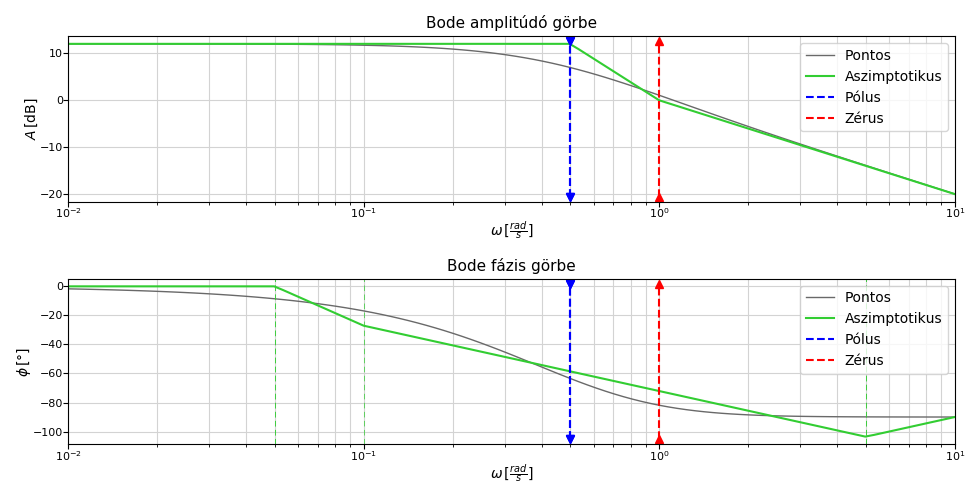

Output()

In [4]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [], lw=1, color='dimgrey')
f1_line3, = f1_ax1.plot([], [], lw=1, color='dimgrey')
f1_line2, = f1_ax2.plot([], [], lw=1.5, color='limegreen')
f1_line4, = f1_ax2.plot([], [], lw=1.5, color='limegreen')

f1_line5, = f1_ax1.plot([], [], color='blue', ls='--')
f1_line6, = f1_ax1.plot([], [], color='blue', ls='--')
f1_line7, = f1_ax1.plot([], [], color='red', ls='--')

f1_line8, = f1_ax2.plot([], [], color='blue', ls='--')
f1_line9, = f1_ax2.plot([], [], color='blue', ls='--')
f1_line10, = f1_ax2.plot([], [], color='red', ls='--')

f1_line11, = f1_ax2.plot([], [])
f1_line12, = f1_ax2.plot([], [])
f1_line13, = f1_ax2.plot([], [])
f1_line14, = f1_ax2.plot([], [])
f1_line15, = f1_ax2.plot([], [])
f1_line16, = f1_ax2.plot([], [])


f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='x', tight=True)
f1_ax2.autoscale(enable=True, axis='x', tight=True)
f1_ax1.autoscale(enable=True, axis='y', tight=False)
f1_ax2.autoscale(enable=True, axis='y', tight=False)

f1_ax1.set_title('Bode amplitúdó görbe', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$\omega\/[\frac{rad}{s}]$', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bode fázis görbe', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$\omega\/[\frac{rad}{s}]$', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax1.legend([f1_line1, f1_line2, f1_line5, f1_line7], ['Pontos', 'Aszimptotikus', 'Pólus', 'Zérus'], loc='upper right')
f1_ax2.legend([f1_line3, f1_line4, f1_line8, f1_line10], ['Pontos', 'Aszimptotikus', 'Pólus', 'Zérus'], loc='upper right')

# System model

def draw_bode(P1, P2, Z, Zb, model):

    if model == 0:
        if Zb:
            W = c.tf([1, Z], [1, P1])
        else:
            W = c.tf([1], [1, P1])
    elif model == 1:
        if Zb:
            W = c.tf([P2, P2*Z], [1, P1, 0])
        else:
            W = c.tf([P2], [1, P1, 0])
    elif model == 2:
         W = c.tf([P2, 0], [1, P1])
    elif model == 3:
        if Zb:
            W = c.tf([1, Z], [1, P1+P2, P1*P2])
        else:
            W = c.tf([1], [1, P1+P2, P1*P2])
    else:
        if Zb:
            W = c.tf([1, Z], [1, 2*P1*P2, P1*P1])
        else:
            W = c.tf([1], [1, 2*P1*P2, P1*P1])            
    
    _, _, ob = c.bode_plot(W, Plot=False)   # Small resolution plot to determine bounds
    
    mag, phase, omega = c.bode_plot(W, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 100), Plot=False)   # Bode-plot         
    poles, zeros = c.pzmap(W, Plot=False) # Poles and zeros
    
    log_omega = np.log10(omega)    
    
    mag_approx = np.full_like(mag, 20 * np.log10(mag[0]))
    phase_approx = np.full_like(phase, 0)
    
    pole_x = []
    zero_x = []
    break_x = []
    
    for p in poles:
        if p.imag == 0:
            om = abs(p.real)
        else:
            om = np.sqrt(p.real*p.real + p.imag*p.imag)
            
        if om == 0:
            mag_approx = mag_approx - 20 * (log_omega - np.log10(omega[0]))
            phase_approx = phase_approx - 90
        else:
            mag_approx = mag_approx - 20 * np.maximum(log_omega - np.log10(om), 0)
            phase_approx = phase_approx + 45 * np.maximum(log_omega - np.log10(om) - 1, 0)
            phase_approx = phase_approx - 45 * np.maximum(log_omega - np.log10(om) + 1, 0)
            
            pole_x.append(om)
            break_x.append(om/10)
            break_x.append(om*10)
            
    for z in zeros:
        if z.imag == 0:
            om = abs(z.real)
        else:
            om = np.sqrt(z.real*z.real + z.imag*z.imag)
            
        if om == 0:
            mag_approx = mag_approx + 20 * (log_omega - np.log10(omega[0]))
            phase_approx = phase_approx + 90
        else:
            mag_approx = mag_approx + 20 * np.maximum(log_omega - np.log10(om), 0)
            phase_approx = phase_approx - 45 * np.maximum(log_omega - np.log10(om) - 1, 0)
            phase_approx = phase_approx + 45 * np.maximum(log_omega - np.log10(om) + 1, 0)
            
            zero_x.append(om)
            break_x.append(om/10)
            break_x.append(om*10)
            
    global f1_line1, f1_line2, f1_line3, f1_line4
    global f1_line5, f1_line6, f1_line7, f1_line8, f1_line9, f1_line10
    global f1_line11, f1_line12, f1_line13, f1_line14, f1_line15, f1_line16
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax1.lines.remove(f1_line3)
    f1_ax2.lines.remove(f1_line2)
    f1_ax2.lines.remove(f1_line4)

    f1_line1, = f1_ax1.plot(omega, 20*np.log10(mag), lw=1, color='dimgrey')
    f1_line3, = f1_ax1.plot(omega, mag_approx, lw=1.5, color='limegreen')
    f1_line2, = f1_ax2.plot(omega, phase*180/np.pi, lw=1, color='dimgrey')   
    f1_line4, = f1_ax2.plot(omega, phase_approx, lw=1.5, color='limegreen')
    
    f1_ax1.lines.remove(f1_line5)
    f1_ax1.lines.remove(f1_line6)
    f1_ax1.lines.remove(f1_line7)
    f1_ax2.lines.remove(f1_line8)
    f1_ax2.lines.remove(f1_line9)
    f1_ax2.lines.remove(f1_line10)
    
    if len(pole_x) >= 1:
        f1_line5 = f1_ax1.axvline(pole_x[0], color='blue', ls='--', ymin=0.03, ymax=0.97, marker='v')
        f1_line8 = f1_ax2.axvline(pole_x[0], color='blue', ls='--', ymin=0.03, ymax=0.97, marker='v')
    else:
        f1_line5, = f1_ax1.plot([], [])
        f1_line8, = f1_ax2.plot([], [])
    if len(pole_x) == 2:
        f1_line6 = f1_ax1.axvline(pole_x[1], color='blue', ls='--', ymin=0.03, ymax=0.97, marker='v')
        f1_line9 = f1_ax2.axvline(pole_x[1], color='blue', ls='--', ymin=0.03, ymax=0.97, marker='v')
    else:
        f1_line6, = f1_ax1.plot([], [])
        f1_line9, = f1_ax2.plot([], [])
    if len(zero_x) == 1:
        f1_line7 = f1_ax1.axvline(zero_x[0], color='red', ls='--', ymin=0.03, ymax=0.97, marker='^')
        f1_line10 = f1_ax2.axvline(zero_x[0], color='red', ls='--', ymin=0.03, ymax=0.97, marker='^')
    else:
        f1_line7, = f1_ax1.plot([], [])
        f1_line10, = f1_ax2.plot([], [])
        
    f1_ax2.lines.remove(f1_line11)
    f1_ax2.lines.remove(f1_line12)
    f1_ax2.lines.remove(f1_line13)
    f1_ax2.lines.remove(f1_line14)
    f1_ax2.lines.remove(f1_line15)
    f1_ax2.lines.remove(f1_line16)
        
    if len(break_x) >= 1:
        f1_line11 = f1_ax2.axvline(break_x[0], color='limegreen', lw=0.5, ls=(0, (8, 5)))
        f1_line12 = f1_ax2.axvline(break_x[1], color='limegreen', lw=0.5, ls=(0, (8, 5)))
    else:
        f1_line11, = f1_ax2.plot([], [])
        f1_line12, = f1_ax2.plot([], [])
        
    if len(break_x) >= 3:
        f1_line13 = f1_ax2.axvline(break_x[2], color='limegreen', lw=0.5, ls=(0, (8, 5)))
        f1_line14 = f1_ax2.axvline(break_x[3], color='limegreen', lw=0.5, ls=(0, (8, 5)))
    else:
        f1_line13, = f1_ax2.plot([], [])
        f1_line14, = f1_ax2.plot([], [])
           
    if len(break_x) >= 5:
        f1_line15 = f1_ax2.axvline(break_x[4], color='limegreen', lw=0.5, ls=(0, (8, 5)))
        f1_line16 = f1_ax2.axvline(break_x[5], color='limegreen', lw=0.5, ls=(0, (8, 5)))
    else:
        f1_line15, = f1_ax2.plot([], [])
        f1_line16, = f1_ax2.plot([], [])

    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    

def link_controls(model):
    w.interactive_output(draw_bode, {'P1': P1_slider, 'P2': P2_slider, 'Z': Z_slider,
                                     'Zb': Z_button, 'model': systemSelect})
    
w.interactive_output(link_controls, {'model': systemSelect})